## Setup
Import necessary libraries and load repository.

In [1]:
def in_colab() -> bool:
    try:
        import google.colab  # noqa: F401
        return True
    except Exception:
        return False

if in_colab():
    !git clone https://github.com/MaxSpeer/applied-computer-vision-assignment2.git
    %cd applied-computer-vision-assignment2
    !pip install -r requirements.txt
    !pip install -e .
else:
    from pathlib import Path
    import sys
    project_root = Path("..").resolve()
    sys.path.append(str(project_root))

In [2]:
import numpy as np
from PIL import Image, ImageShow
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
def in_colab() -> bool:
    try:
        import google.colab  # noqa: F401
        return True
    except Exception:
        return False

if in_colab():
    !git clone https://github.com/MaxSpeer/applied-computer-vision-assignment2.git
    %cd applied-computer-vision-assignment2
    !pip install -r requirements.txt
    !pip install -e .
else:
    from pathlib import Path
    import sys
    project_root = Path("..").resolve()
    sys.path.append(str(project_root))

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

## Load Data

In [5]:
import fiftyone as fo
from fiftyone.utils.huggingface import load_from_hub

#fo.delete_dataset("multimodal-shapes-subset")
dataset_hf = load_from_hub("maxspeer/assessment2_spheres_and_cube_2k_2",
                         name="multimodal-shapes-subset",
                         num_workers=4,
                         batch_size=500,
                        #max_samples=3000,
                           overwrite=True
                        )

# fiftyone session
session = fo.launch_app(dataset_hf, auto=False)
print(session.url)

/Users/maximilian/miniforge3/envs/compv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading dataset
Importing samples...
 100% |███████████████| 6000/6000 [51.8ms elapsed, 0s remaining, 115.8K samples/s]  
Session launched. Run `session.show()` to open the App in a cell output.
http://localhost:5151/


In [6]:
from src.datasets import MultimodalDataset

IMG_SIZE = 64
BATCH_SIZE = 32


img_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Scales data into [0,1] TODO correct non deprecated version
])

train_dataset = MultimodalDataset(dataset_hf,"train",img_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


val_dataset = MultimodalDataset(dataset_hf,"val",img_transforms)
valid_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

## Define the CILP model

In [7]:
CILP_EMB_SIZE = 200

class Embedder(nn.Module):
    def __init__(self, in_ch, emb_size=CILP_EMB_SIZE):
        super().__init__()
        kernel_size = 3
        stride = 1
        padding = 1

        # Convolution
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, 50, kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(50, 100, kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(100, 200, kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(200, 200, kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(200 * 4 * 4, 100),
            nn.ReLU(),
            nn.Linear(100, emb_size)
        )

    def forward(self, x):
        conv = self.conv(x)
        emb = self.dense_emb(conv)
        return F.normalize(emb)

In [8]:
img_embedder = Embedder(4).to(device)
lidar_embedder = Embedder(1).to(device)

In [9]:
class ContrastivePretraining(nn.Module):
    def __init__(self):
        super().__init__()
        self.img_embedder = img_embedder
        self.lidar_embedder = lidar_embedder
        self.cos = nn.CosineSimilarity(dim=1)

    def forward(self, rgb_imgs, lidar_depths):
        img_emb = self.img_embedder(rgb_imgs)
        lidar_emb = self.lidar_embedder(lidar_depths)

        repeated_img_emb = img_emb.repeat_interleave(len(img_emb), dim=0)
        repeated_lidar_emb = lidar_emb.repeat(len(lidar_emb), 1)

        similarity = self.cos(repeated_img_emb, repeated_lidar_emb)
        similarity = torch.unflatten(similarity, 0, (BATCH_SIZE, BATCH_SIZE))
        similarity = (similarity + 1) / 2
        
        logits_per_img = similarity / 0.07   # Introduce temperature scaling
        logits_per_lidar = logits_per_img.T


        return logits_per_img, logits_per_lidar

In [10]:
CILP_model = ContrastivePretraining().to(device)
optimizer = Adam(CILP_model.parameters(), lr=0.0001)
loss_img = nn.CrossEntropyLoss()
loss_lidar = nn.CrossEntropyLoss()
ground_truth = torch.arange(BATCH_SIZE, dtype=torch.long).to(device)
epochs = 3

In [11]:
def get_CILP_loss(batch):
    rbg_img = batch[0].to(device)
    lidar_depth = batch[2].to(device)
    class_idx = batch[3].to(device)

    logits_per_img, logits_per_lidar = CILP_model(rbg_img, lidar_depth)

    total_loss = (loss_img(logits_per_img, ground_truth) +
        loss_lidar(logits_per_lidar, ground_truth)
    ) / 2

    return total_loss, logits_per_img

## Perform pretraining
Save the best model checkpoint

In [12]:
import copy
import torch
import wandb
from src.training import getWandbRun

# Make sure CILP is trainable
for p in CILP_model.parameters():
    p.requires_grad = True
CILP_model.train()

best_val = float("inf")
best_epoch = -1
best_ckpt = None

batch_size = BATCH_SIZE
epochs = 10

with getWandbRun("CILP_Pretraining","rgb/lidar", batch_size=batch_size, epochs=epochs, project_name="assessment2_notebook4") as run:

    for epoch in range(epochs):
        # ---------------- train ----------------
        CILP_model.train()
        train_loss = 0.0
        n_train = 0

        for batch in train_dataloader:
            optimizer.zero_grad(set_to_none=True)

            loss, logits_per_img = get_CILP_loss(batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            n_train += 1

        train_avg = train_loss / max(n_train, 1)
        print(f"Epoch {epoch} | Train loss: {train_avg:.6f}")

        # ---------------- valid ----------------
        CILP_model.eval()
        valid_loss = 0.0
        n_val = 0
        with torch.no_grad():
            for batch in valid_dataloader:
                loss, logits_per_img = get_CILP_loss(batch)
                valid_loss += loss.item()
                n_val += 1

        val_avg = valid_loss / max(n_val, 1)
        print(f"Epoch {epoch} | Valid loss: {val_avg:.6f}")

        # Log to W&B
        run.log(
            {
                "epoch": epoch,
                "train_loss": train_avg,
                "valid_loss": val_avg,
                "learning_rate": optimizer.param_groups[0]["lr"],
            },
            step=epoch,
        )

        # Track best checkpoint so far
        if val_avg < best_val:
            best_val = val_avg
            best_epoch = epoch
            best_ckpt = {
                "epoch": epoch,
                "best_val_loss": best_val,
                "model_state_dict": {k: v.detach().cpu().clone() for k, v in CILP_model.state_dict().items()},
                "optimizer_state_dict": copy.deepcopy(optimizer.state_dict()),
            }
            print(f"New best at epoch {epoch}: {best_val:.6f}")

    # Save best checkpoint
    save_path = "../checkpoints/CILP_best.pt"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save(best_ckpt, save_path)
    print(f"Saved best checkpoint from epoch {best_epoch} to {save_path} (val={best_val:.6f})")

    artifact = wandb.Artifact("CILP_best", type="model")
    artifact.add_file(save_path)
    run.log_artifact(artifact)

    run.finish()


wandb: Currently logged in as: maximilian-speer (maximilian-speer-hasso-plattner-institut) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb.init fertig
Epoch 0 | Train loss: 2.751806
Epoch 0 | Valid loss: 2.009115
New best at epoch 0: 2.009115
Epoch 1 | Train loss: 1.784196
Epoch 1 | Valid loss: 1.576897
New best at epoch 1: 1.576897
Epoch 2 | Train loss: 1.443317
Epoch 2 | Valid loss: 1.270553
New best at epoch 2: 1.270553
Epoch 3 | Train loss: 1.237929
Epoch 3 | Valid loss: 1.183027
New best at epoch 3: 1.183027
Epoch 4 | Train loss: 1.124260
Epoch 4 | Valid loss: 1.089082
New best at epoch 4: 1.089082
Epoch 5 | Train loss: 1.047254
Epoch 5 | Valid loss: 0.976468
New best at epoch 5: 0.976468
Epoch 6 | Train loss: 0.959458
Epoch 6 | Valid loss: 0.954871
New best at epoch 6: 0.954871
Epoch 7 | Train loss: 0.892827
Epoch 7 | Valid loss: 0.873183
New best at epoch 7: 0.873183
Epoch 8 | Train loss: 0.837689
Epoch 8 | Valid loss: 0.834657
New best at epoch 8: 0.834657
Epoch 9 | Train loss: 0.793898
Epoch 9 | Valid loss: 0.799837
New best at epoch 9: 0.799837
Saved best checkpoint from epoch 9 to ../checkpoints/CILP_best

epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▃▂▂▂▁▁▁
valid_loss,█▅▄▃▃▂▂▁▁▁
epoch,9
learning_rate,0.0001
train_loss,0.7939


In [13]:
# Projektor image embeddings to lidar
projector = nn.Sequential(
    nn.Linear(200, 512),
    nn.ReLU(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 3200),
).to(device)

In [15]:
from src.models import Classifier

lidar_cnn = Classifier(1).to(device)
lidar_cnn.load_state_dict(torch.load("../lidar_cnn.pt", weights_only=True, map_location=torch.device('cpu')))

for param in lidar_cnn.parameters():
    param.requires_grad = False
lidar_cnn.eval()

Classifier(
  (embedder): Sequential(
    (0): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3200, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [16]:
def get_projector_loss(model, batch):
    rbg_img = batch[0].to(device)
    lidar_depth = batch[2].to(device)
    class_idx = batch[3].to(device)

    # rbg_img, lidar_depth, class_idx = batch
    imb_embs = CILP_model.img_embedder(rbg_img)
    lidar_emb = lidar_cnn.get_embs(lidar_depth)
    pred_lidar_embs = model(imb_embs)
    return nn.MSELoss()(pred_lidar_embs, lidar_emb)

## Train the projector

In [ ]:
optimizer = torch.optim.AdamW(projector.parameters(), lr=3e-4, weight_decay=1e-4)

for p in CILP_model.parameters():
    p.requires_grad = False
for p in lidar_cnn.parameters():
    p.requires_grad = False

from src.training import train_model as train_model_projector
epochs = 100

with getWandbRun(
    "Projector_Training",
    "projector",
    batch_size=BATCH_SIZE,
    epochs=epochs,
    project_name="assessment2_notebook4"
) as wandbrun:
    train_model_projector(projector, optimizer, get_projector_loss, epochs, train_dataloader, valid_dataloader, wandbrun=wandbrun)

wandb.init fertig
Epoch   0 | Train Loss: 5.4527
Epoch   0 | Valid Loss: 4.7690
Epoch   1 | Train Loss: 4.7699
Epoch   1 | Valid Loss: 4.5658
Epoch   2 | Train Loss: 4.4658
Epoch   2 | Valid Loss: 4.1209
Epoch   3 | Train Loss: 3.9455
Epoch   3 | Valid Loss: 3.6940
Epoch   4 | Train Loss: 3.5866
Epoch   4 | Valid Loss: 3.4658
Epoch   5 | Train Loss: 3.4225
Epoch   5 | Valid Loss: 3.3530
Epoch   6 | Train Loss: 3.3805
Epoch   6 | Valid Loss: 3.3654
Epoch   7 | Train Loss: 3.2736
Epoch   7 | Valid Loss: 3.2507
Epoch   8 | Train Loss: 3.2630
Epoch   8 | Valid Loss: 3.2707
Epoch   9 | Train Loss: 3.1999
Epoch   9 | Valid Loss: 3.1787
Epoch  10 | Train Loss: 3.1518
Epoch  10 | Valid Loss: 3.2214
Epoch  11 | Train Loss: 3.1259
Epoch  11 | Valid Loss: 3.1616
Epoch  12 | Train Loss: 3.0868
Epoch  12 | Valid Loss: 3.0984
Epoch  13 | Train Loss: 3.0282
Epoch  13 | Valid Loss: 3.0897
Epoch  14 | Train Loss: 3.0039
Epoch  14 | Valid Loss: 3.0216
Epoch  15 | Train Loss: 2.9554
Epoch  15 | Valid Los

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
learning_rate,0.0003
train_loss,1.72544


## Results
View on W&B: https://wandb.ai/maximilian-speer-hasso-plattner-institut/assessment2_notebook4

W&B log for CILP:
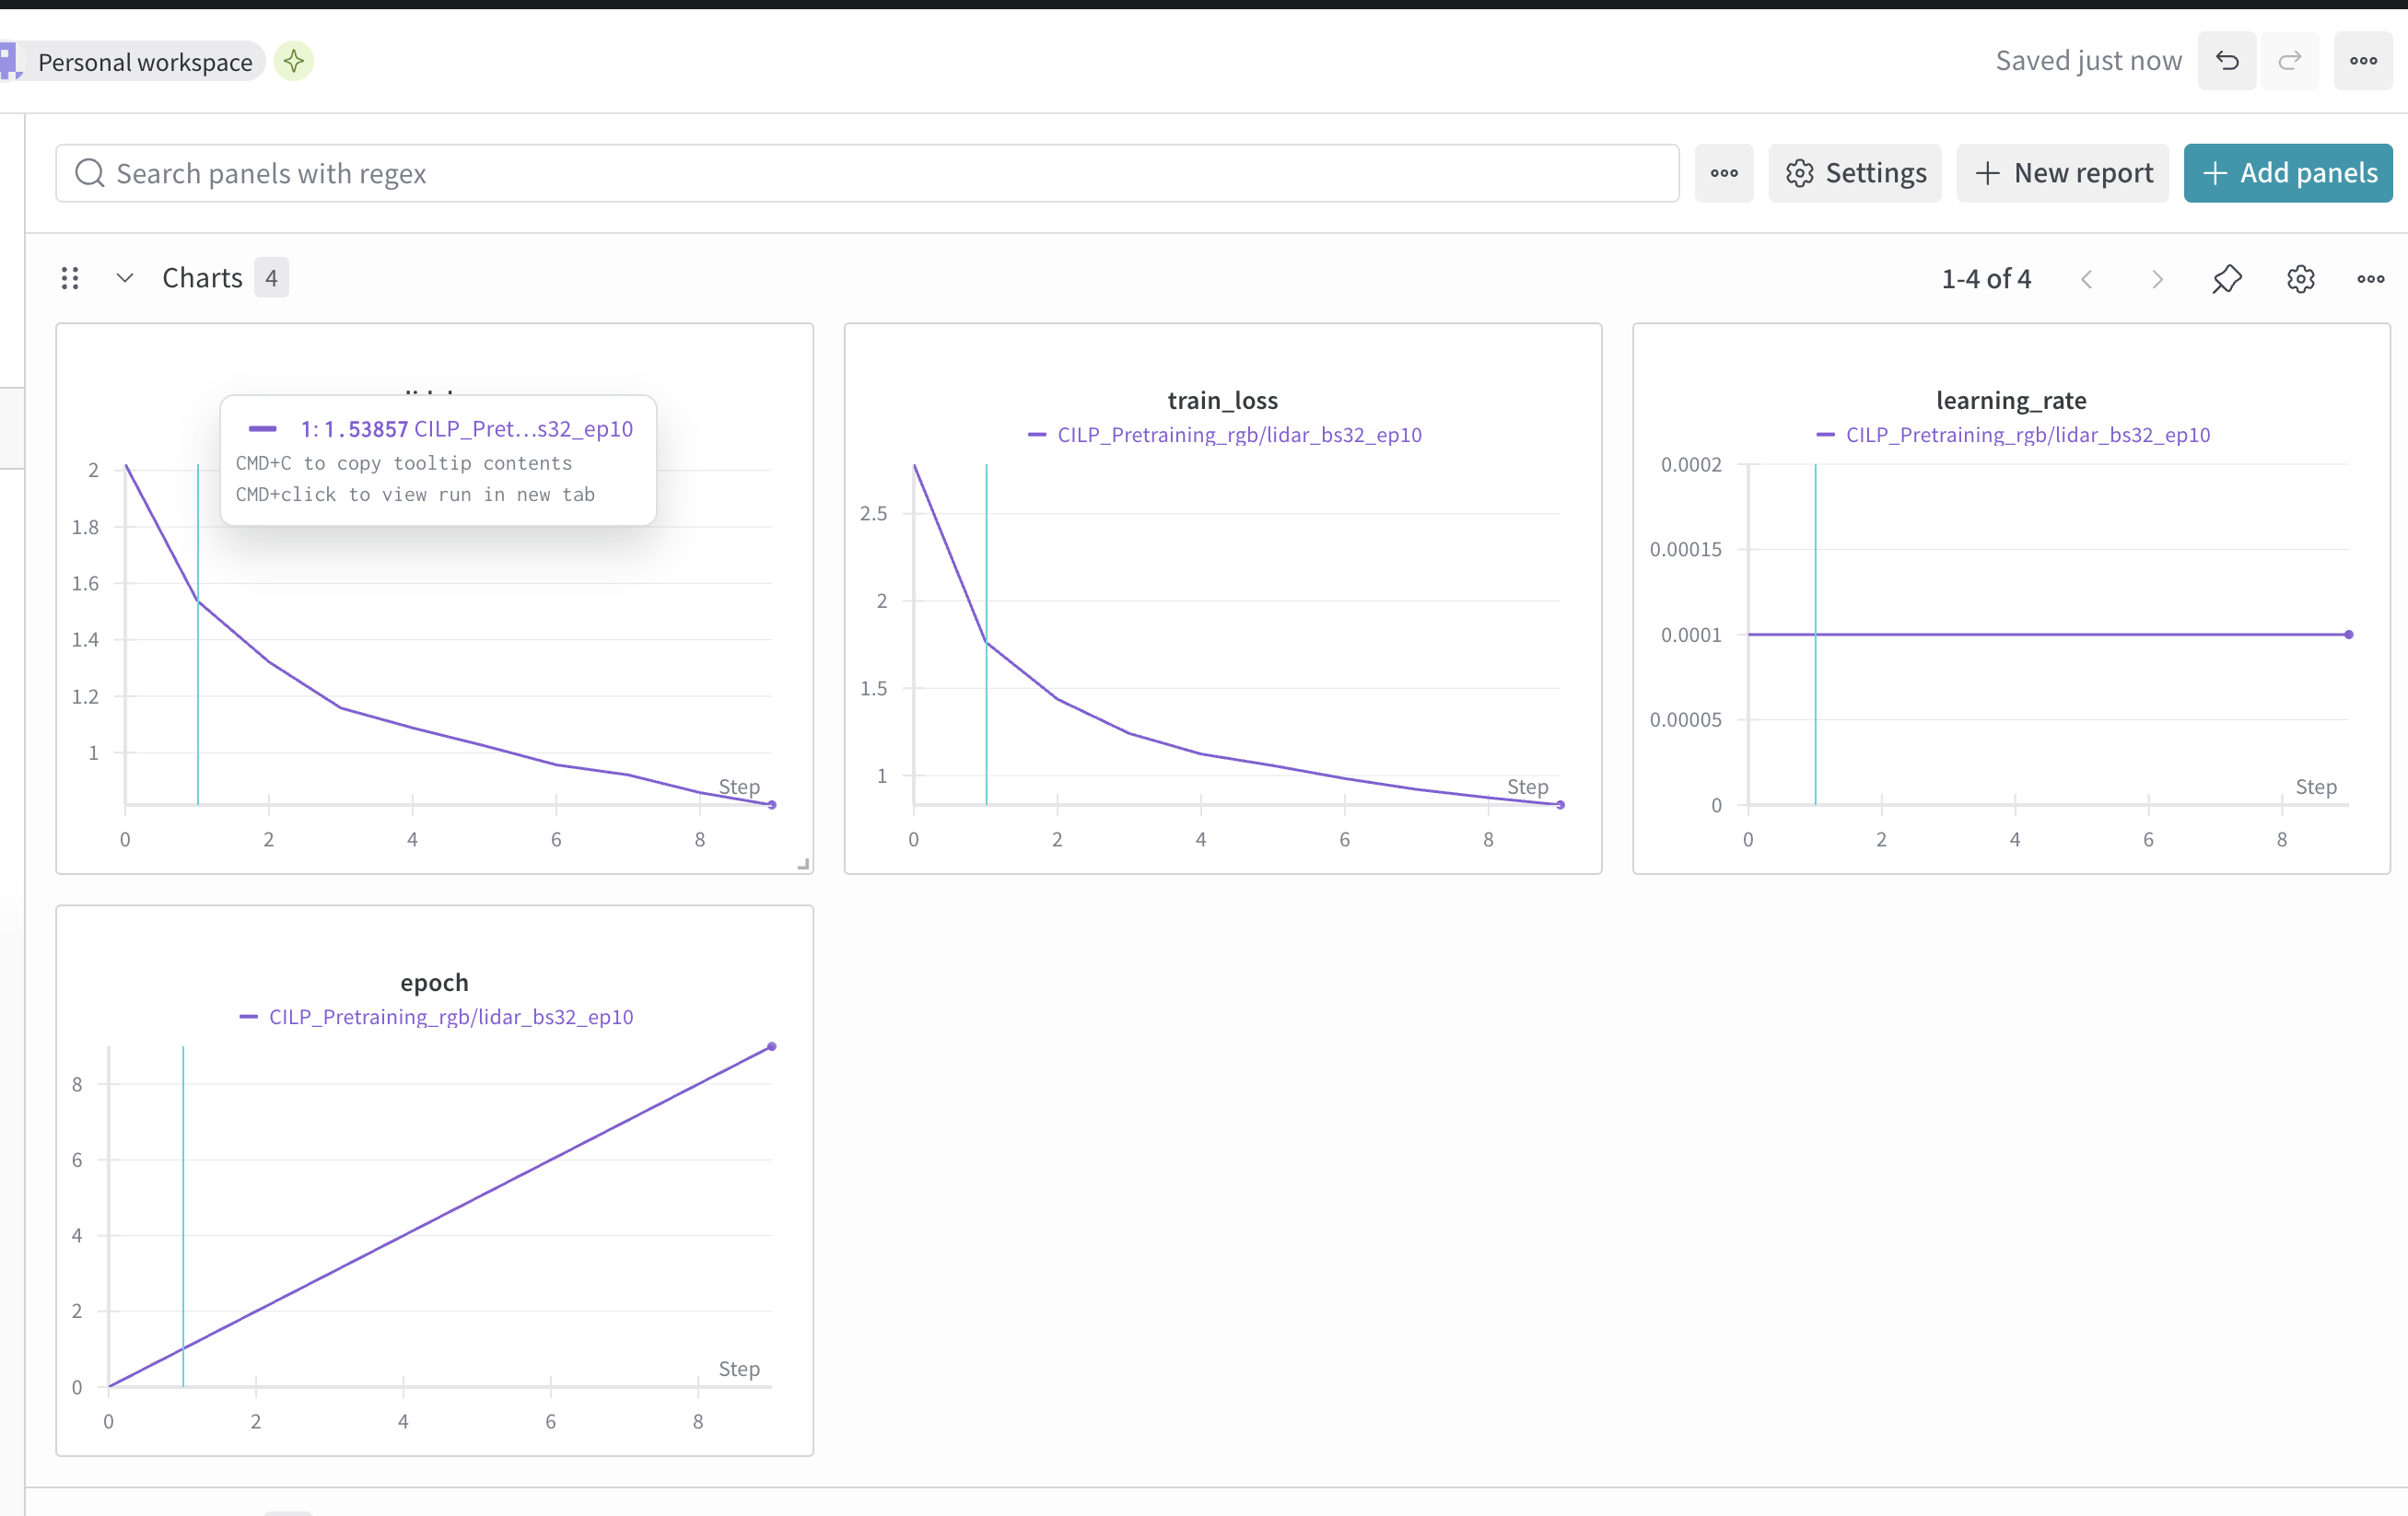

Projector Training:
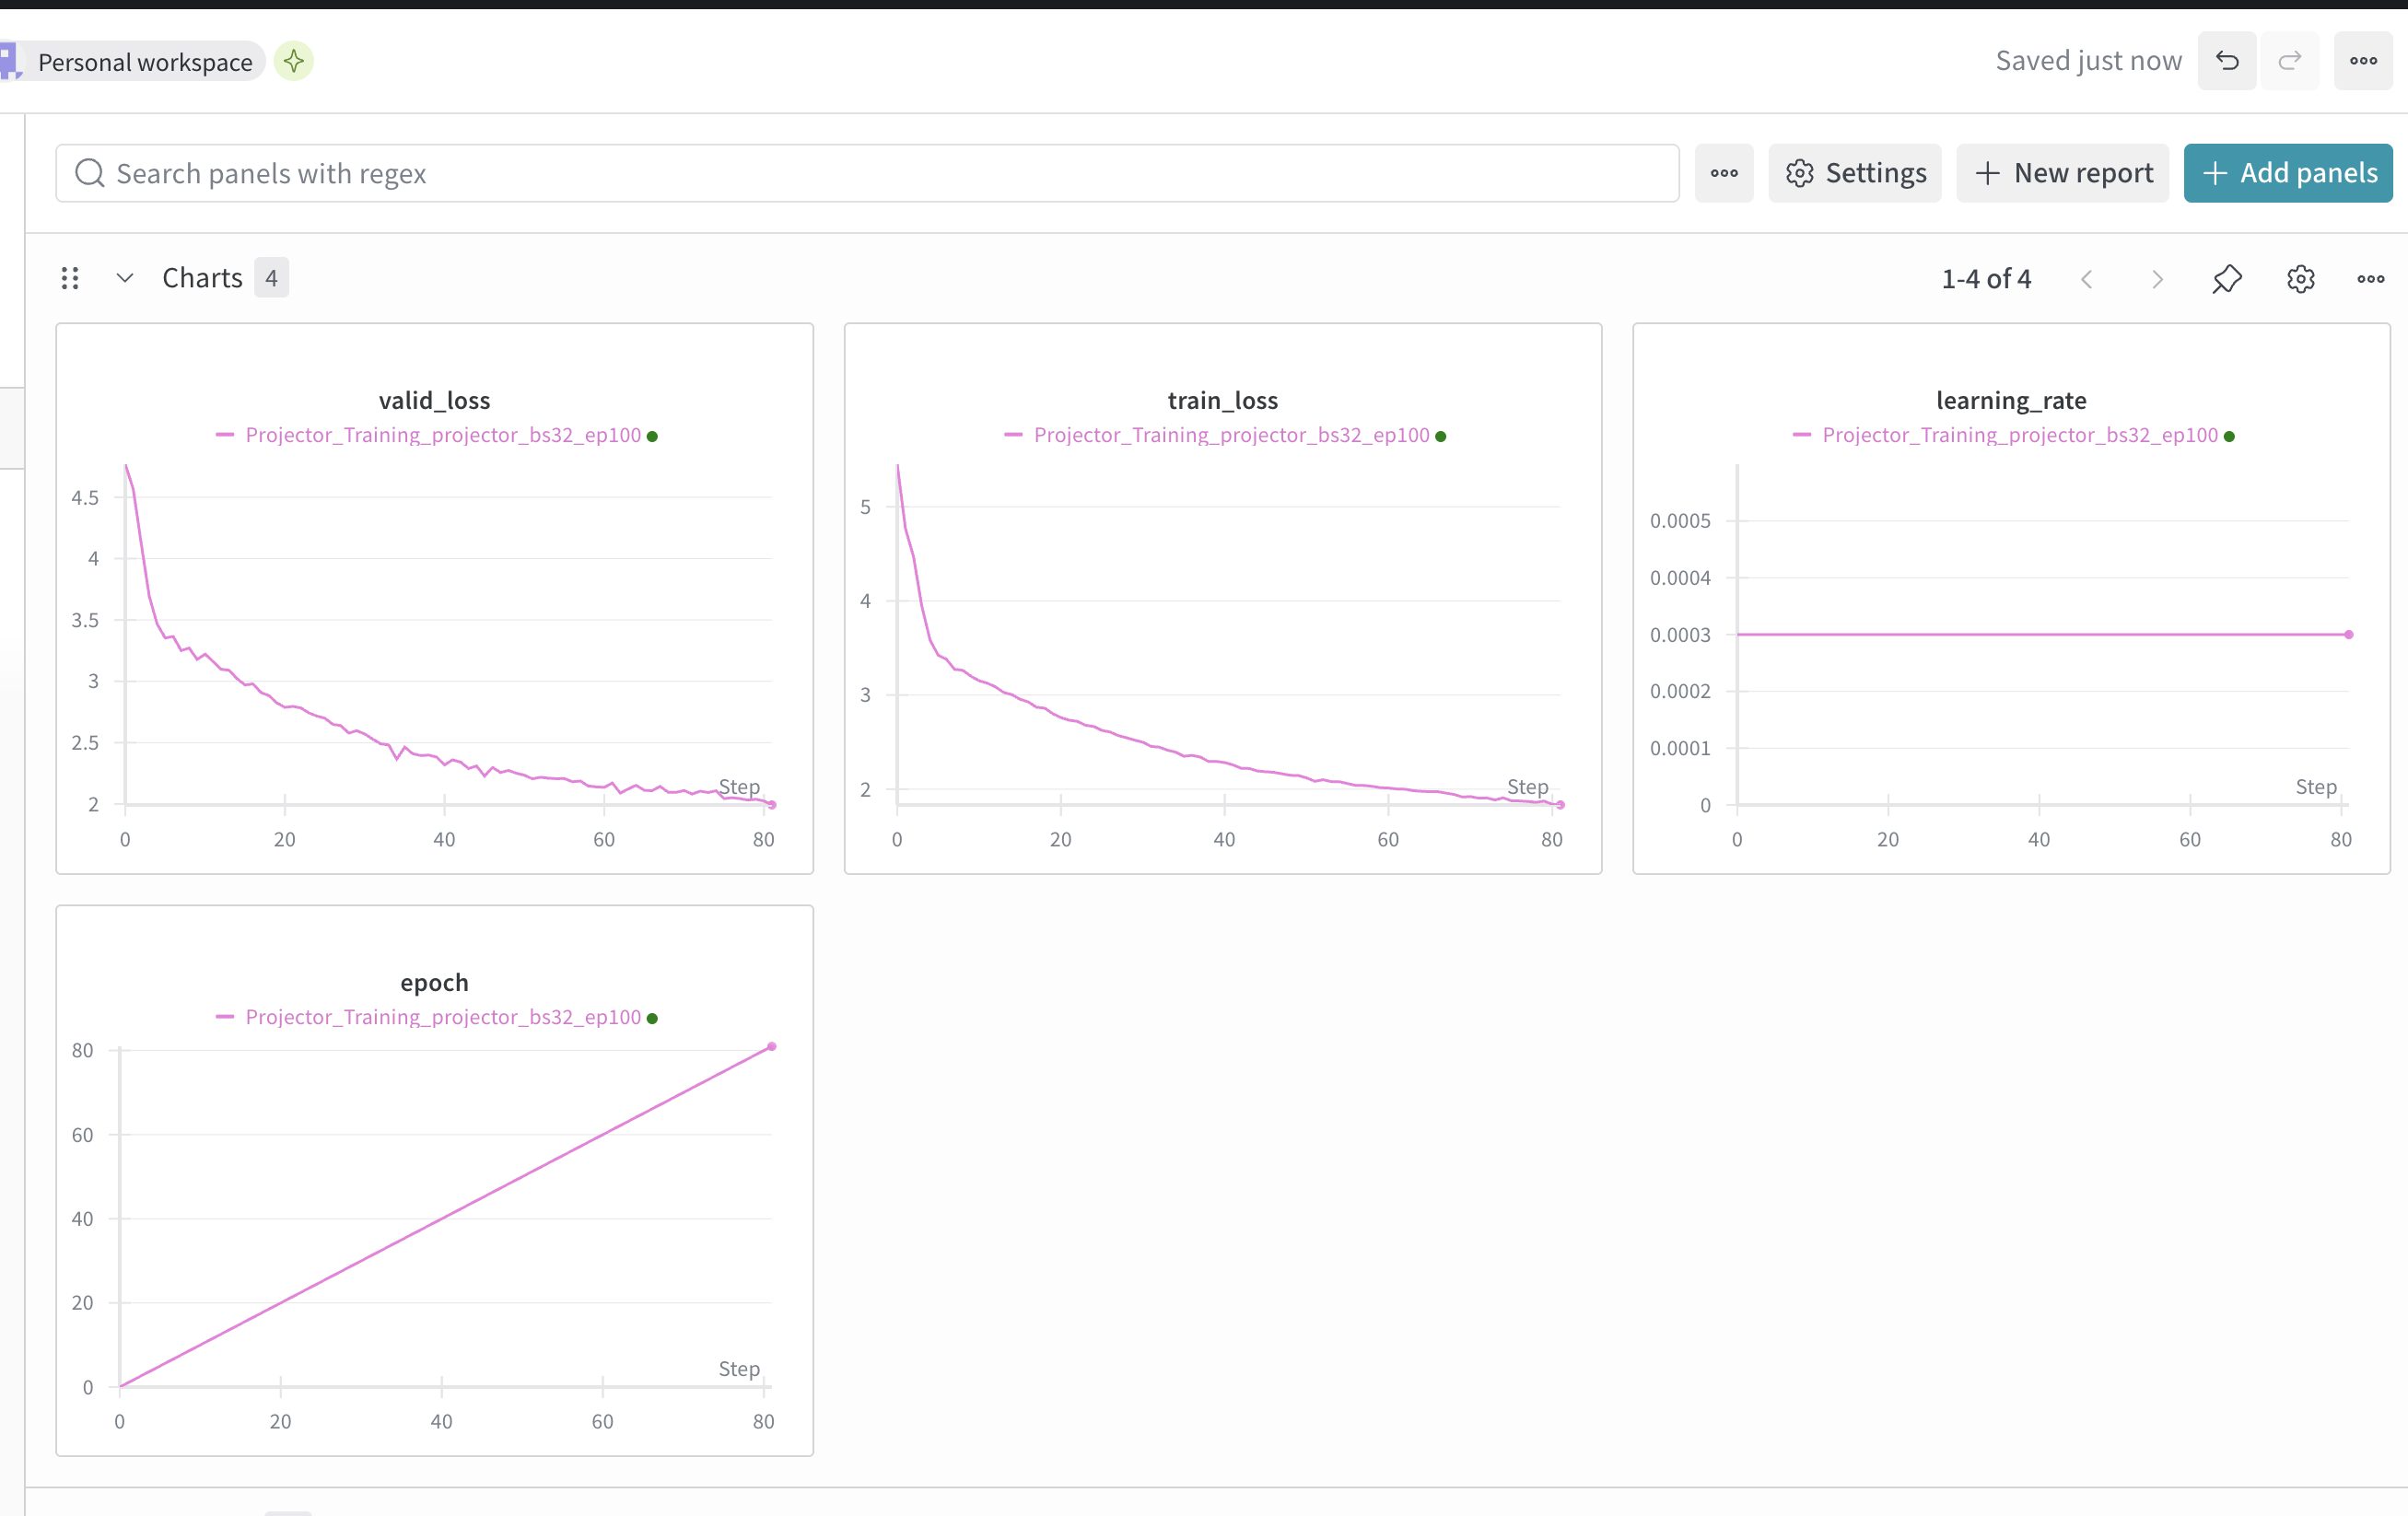

Best Valid Loss: 1.9716